# Preprocessing for image features

This requires numpy, scipy, pillow, cv2, os, requests

In [ ]:
import numpy as np
from PIL import Image as PILImage
import PIL.ImageStat
from IPython.display import Image as IPyImage
import os
from pathlib import Path
import requests
from io import BytesIO
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import sqlite3

In [2]:
SOURCE_IMAGE_DIRECTORY = r'E:\local\TestData\training-images\hjl'
THUMBNAIL_DIRECTORY = r'E:\local\TestData\training-images\thumbnail'
THUMBNAIL_SIZE = 128, 128
STANDARD_IMAGE_DIM = 256

DATASTORE_DIRECTORY = r'E:\local\TestData\training-images'
DATASTORE_NAME = 'datastore.db'

In [3]:
raw_input_queue = []

for dirname, dirnames, filenames in os.walk(SOURCE_IMAGE_DIRECTORY):
    #print(dirname, dirnames, filenames)
    # print path to all subdirectories first.
#    for subdirname in dirnames:
#        print(os.path.join(dirname, subdirname))

    for filename in filenames:
        full_raw_input_path = os.path.join(dirname, filename)
        print('queueing', full_raw_input_path)
        raw_input_queue.append(full_raw_input_path)

print('queued', len(raw_input_queue), 'items')


queueing E:\local\TestData\training-images\hjl\9080540205_077ca98a05_o.jpg
queueing E:\local\TestData\training-images\hjl\8745890385_a4bf97cf70_o.jpg
queueing E:\local\TestData\training-images\hjl\6988939547_d734af8034_o.jpg
queueing E:\local\TestData\training-images\hjl\9498125419_6ccdc0575d_o.jpg
queueing E:\local\TestData\training-images\hjl\9575536980_ab788e76a9_o.jpg
queueing E:\local\TestData\training-images\hjl\14961861191_939396d3bd_o.jpg
queueing E:\local\TestData\training-images\hjl\26153910890_9d454af6e6_o.jpg
queueing E:\local\TestData\training-images\hjl\10487234964_75368e3ab5_o.jpg
queueing E:\local\TestData\training-images\hjl\9624735029_27dc504663_o.jpg
queueing E:\local\TestData\training-images\hjl\8827012370_ca7cf39ac0_o.jpg
queueing E:\local\TestData\training-images\hjl\25464585526_9df4ccef92_o.jpg
queueing E:\local\TestData\training-images\hjl\24842360564_cbc68dc8d0_o.jpg
queued 12 items


In [4]:
def make_item_record(item):
    item_properties = dict()
    item_properties['size'] = os.path.getsize(item)
    item_properties['dirname'] = os.path.dirname(item)
    item_properties['filename'] = os.path.basename(item)
    item_properties['ctime'] = os.path.getctime(item)
    item_properties['fullpath'] = item

    return item_properties



In [20]:
def generate_standardized_image(item):
    image_properties = dict()
    im = PILImage.open(item)
    image_properties['width'] = im.width
    image_properties['height'] = im.height
    image_properties['format'] = im.mode
    
    im_thumb = im.copy()
    im.thumbnail(THUMBNAIL_SIZE)
    im_thumb_filename = Path(item).stem
    im_thumb_filename = im_thumb_filename + '_thumb' + '.jpg'
    im_thumb_path = os.path.join(THUMBNAIL_DIRECTORY, im_thumb_filename)
    im_thumb.save(im_thumb_path, 'JPEG')
    im_stat = PIL.ImageStat.Stat(im_thumb)
    print(im_stat.mean)
    meanval = int((im_stat.mean[0] + im_stat.mean[1] + im_stat.mean[2])/3)
    image_properties['mean'] = meanval
    im_thumb.close()
    
    im_standard = im.copy()
    
    
    
    
    im.close()
    
    
    image_properties['thumbpath'] = im_thumb_path
    image_properties['thumbname'] = im_thumb_filename

    return image_properties
    
    

In [23]:
# create a new empty datastore for image metadata
#
# in "datastore.db"
#



datastore_path = os.path.join(DATASTORE_DIRECTORY, DATASTORE_NAME)
print('datastore path is', datastore_path)
p = Path(datastore_path)

if p.is_file():
    # looks like there is already a datastore file, check with user first
#    userConfirm = input(DATASTORE_NAME + " exists, do you really want to start over? (y/n): ")
#    if userConfirm == 'Y':
#        print("deleting old datastore and reinitializing...")
#    else:
#        print("nothing done")
#        sys.exit(0)
    print('removing existing datastore!')
    # OK, delete datastore and start over
    os.remove(datastore_path)

# create a new empty datastore 
print("creating new datastore " + DATASTORE_NAME)
conn = sqlite3.connect(datastore_path)
cursor = conn.cursor()

# create tables (this will completely reset db)
cursor.execute("""CREATE TABLE input_images
                (
                width int,
                height int,
                mean int,
                filename text,
                thumbname text)
                """)
conn.commit()


datastore path is E:\local\TestData\training-images\datastore.db
removing existing datastore!
creating new datastore datastore.db


In [25]:
def db_add_record(conn, width, height, mean, filename, thumbname):
    cursor = conn.cursor()
    datum = [(width, height, mean, filename, thumbname)]
    cursor.executemany("INSERT INTO input_images VALUES (?, ?, ?, ?, ?)", datum)
    conn.commit()

In [26]:
for item in raw_input_queue:
    print('processing', item)
    item_info = dict()
    item_info['source_file'] = make_item_record(item)
    item_info['source_image'] = generate_standardized_image(item)
    db_add_record(conn, item_info['source_image']['width'], item_info['source_image']['height'], 
                item_info['source_image']['mean'],
                item_info['source_file']['filename'], item_info['source_image']['thumbname'])
#    print(make_item_record(item))
#    print(generate_standardized_image(item))
    print(item_info)
    

processing E:\local\TestData\training-images\hjl\9080540205_077ca98a05_o.jpg
[60.59601965017564, 60.59601965017564, 60.59601965017564]
{'source_file': {'fullpath': 'E:\\local\\TestData\\training-images\\hjl\\9080540205_077ca98a05_o.jpg', 'dirname': 'E:\\local\\TestData\\training-images\\hjl', 'ctime': 1500926567.04, 'size': 493606, 'filename': '9080540205_077ca98a05_o.jpg'}, 'source_image': {'thumbname': '9080540205_077ca98a05_o_thumb.jpg', 'width': 1280, 'thumbpath': 'E:\\local\\TestData\\training-images\\thumbnail\\9080540205_077ca98a05_o_thumb.jpg', 'format': 'RGB', 'height': 854, 'mean': 60}}
processing E:\local\TestData\training-images\hjl\8745890385_a4bf97cf70_o.jpg
[55.51000879249707, 49.53109429953107, 56.634518793962485]
{'source_file': {'fullpath': 'E:\\local\\TestData\\training-images\\hjl\\8745890385_a4bf97cf70_o.jpg', 'dirname': 'E:\\local\\TestData\\training-images\\hjl', 'ctime': 1500926567.11, 'size': 996586, 'filename': '8745890385_a4bf97cf70_o.jpg'}, 'source_image': {

In [ ]:
conn = sqlite3.connect(datastore_path)

In [28]:
conn.close()

In [ ]:
db_add_record(conn, 128,128, 'test.jpg', 'test_thumb.jpg')

In [29]:
conn = sqlite3.connect(datastore_path)
cursor = conn.cursor()
cursor.execute('select * from input_images')
rows = cursor.fetchall()
for r in rows:
    print (r)
conn.close()

(1280, 854, 60, '9080540205_077ca98a05_o.jpg', '9080540205_077ca98a05_o_thumb.jpg')
(1280, 853, 53, '8745890385_a4bf97cf70_o.jpg', '8745890385_a4bf97cf70_o_thumb.jpg')
(1024, 683, 38, '6988939547_d734af8034_o.jpg', '6988939547_d734af8034_o_thumb.jpg')
(1280, 853, 89, '9498125419_6ccdc0575d_o.jpg', '9498125419_6ccdc0575d_o_thumb.jpg')
(1280, 853, 176, '9575536980_ab788e76a9_o.jpg', '9575536980_ab788e76a9_o_thumb.jpg')
(960, 1280, 152, '14961861191_939396d3bd_o.jpg', '14961861191_939396d3bd_o_thumb.jpg')
(853, 1280, 44, '26153910890_9d454af6e6_o.jpg', '26153910890_9d454af6e6_o_thumb.jpg')
(960, 1280, 108, '10487234964_75368e3ab5_o.jpg', '10487234964_75368e3ab5_o_thumb.jpg')
(1280, 853, 104, '9624735029_27dc504663_o.jpg', '9624735029_27dc504663_o_thumb.jpg')
(1280, 853, 47, '8827012370_ca7cf39ac0_o.jpg', '8827012370_ca7cf39ac0_o_thumb.jpg')
(853, 1280, 100, '25464585526_9df4ccef92_o.jpg', '25464585526_9df4ccef92_o_thumb.jpg')
(853, 1280, 77, '24842360564_cbc68dc8d0_o.jpg', '24842360564_cb

In [30]:
cvim = cv2.imread(r'E:\local\TestData\training-images\hjl\6988939547_d734af8034_o.jpg')

In [31]:
cvim.shape

(683, 1024, 3)

<function matplotlib.pyplot.show>

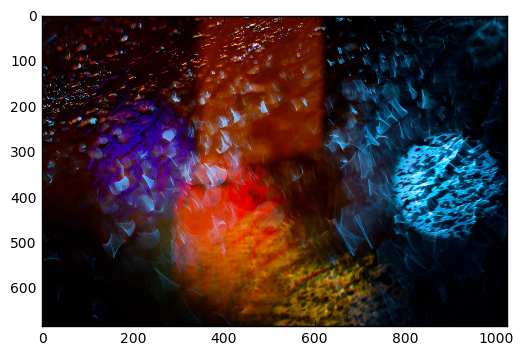

In [32]:
plt.imshow(cvim)
plt.show